# DQN Cart Pole Project
- NN
- Experience: to generate data
- Replay Memory: to store experience

No optimization and no instruction for when to end an episode

In [1]:
# import gym
# env = gym.make("CartPole-v0")
# env.reset()
# for _ in range(1000):
#     env.render()
#     env.step(env.action_space.sample())
# env.close()

## Import Libraries

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count 
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from typing import Tuple, List

## Set up display

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## DQN

In [4]:
class DQN(nn.Module):
    def __init__(self, img_height: int, img_width: int):
        """DQN class
        
        Parameters
        ----------
        img_height: int
            image height
        img_widge: int
            image width
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features = 24) 
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2) #2 = moving left or right
    
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """Feedforward of DQN;
        
        Parameters
        ----------
        t: torch.Tensor
            input image
            
        Return
        ----------
        t: torch.Tensor
            action left or right of the cartpole
        """
        t = t.flatten(start_dim=1)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.out(t)
        return t

## Experience Class:
- Play the environment to generate data input to nn
- Experiences is what will be replayed and used as input to nn

In [5]:
Experience = namedtuple("Experience", ("state", "action", "next_state", "reward"))

In [6]:
# Experience object ex
e = Experience(2,3,1,4)

In [7]:
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay memory class to store experience

In [8]:
class ReplayMemory():
    def __init__(self, capacity: int):
        """Replay Memory class
        
        Parameters
        ----------
        capacity: int
            capacity of the memory
        """
        self.capacity = capacity
        self.memory = []
        self.push_count = 0 # keep track how many experience we have in a memory
    
    def push(self, experience: Experience):
        """Push the experience into the memory
        
        Parameters
        ----------
        experience: Experience
            played experience
        """
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else: # if the memory full then we push new exp to the front of the memory
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    def sample(self, batch_size: int) -> List:
        """Sample in the memory dataset with batch_size number of experience
        
        Parameters
        ----------
        batch_size: int
            batch size
        
        Return
        ----------
        list of experience according to the batch size
        """
        # sample exp to general batch for DQN network
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size) -> bool:
        """Check if have enough data in the list to gather a batch
        
        Parameters
        ----------
        batch_size: int
            size of a batch of experience
        
        Return
        ----------
        boolean of able to get a batch of experience or not
        """
        # check if we have enough data to generate a batch
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy Class

In [9]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        """Exploration vs Exploitation
        
        Parameters
        start:
            start decay value
        end:
            end decay value
        decay:
            decay value
        ----------
        """
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        """Get exploration rate 
        
        Parameters
        ----------
        current_step:
            current step in the training process
        Return
        ----------
        the exploration rate
        """
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent

In [10]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        """RL Agent
        
        Paramaters
        ----------
        strategy:
            epsilon strategy of exploration or exploitation
        num_actions:
            number of actions
        device:
            cpu or gpu
        """
        self.current_step = 0 # current step number in the env
        self.strategy = strategy # epsilon greedy strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        """Select action left or right to take
        
        Parameters
        ----------
        state:
            current state of the agent in the env
        policy_net:
            policy network for generating target (not prediction)
            
        Return:
        ----------
        action to take
        """
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random(): # if the exploration rate > than random rate
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device) # explore the env by randomly selecting the action 0 or 1 left and rihgt action
        else:
            with torch.no_grad(): 
                return policy_net(state).argmax(dim=1).to(device) # exploit with the highest Q value output in the policy networ with a given state

## Image Preprocessing & Env Management

In [11]:
class CartPoleEnvManager():
    def __init__(self, device):
        """Cart Pole Environment Manager
        
        Parameters
        ----------
        device:
            gpu or cpu
        """
        self.device = device
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        """Reset the environment"""
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        """Close the environment"""
        self.env.close()
        
    def render(self, mode="human"):
        """Render the environment for observation"""
        return self.env.render(mode)
    
    #######################################################################
    def num_actions_available(self):
        """Return number of action available to the agent in the environment: left or right
        
        Return
        ----------
        number of actions that available to act
        """
        return self.env.action_space.n
    
    def take_action(self, action: torch.Tensor) -> torch.Tensor:
        """Take left or right action
        
        Parameters
        ----------
        action: torch.Tensor
            left or right action
        
        Return
        ----------
        agent step to action: torch.Tensor
        """
        # .item() return the value of the Tensor
        _, reward, self.done, _ = self.env.step(action.item()) # we only care the reward and if the episode ended or not. self.done here means to updates the current "done" state
        return torch.tensor([reward], device = self.device) # return the reward wrapped by Pytorch Tensor
    
    def just_starting(self) -> bool:
        """Returns true if the current screen is none
        """
        return self.current_screen is None
    
    def get_state(self):
        """Return the current state of the environment in the form of processed image on the screen
        
        Return
        ----------
        state:
        """
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1 # state = different between the current screen and previous screen => allow the agent to take velocity into account
    
    #######################################################################
    def get_screen_height(self):
        """Get Screen Height
        
        Return
        ----------
        height of the screen
        """
        screen = self.get_processed_screen()
        return screen.shape[2]

    
    def get_screen_width(self):
        """Get Screen Width
        
        Return
        ----------
        width of the screen
        """
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        """Get Processed Screen
        
        Return
        ----------
        cropped screen
        """
        screen = self.render("rgb_array").transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        """Cropped Screen
        
        Return
        ----------
        cropped screen
        """
        screen_height = screen.shape[1]
        
        # stip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        """Converts to float, rescale, convert to tensor
        
        Parameters
        ----------
        screen:
            screen 
        """
        screen = np.ascontiguousarray(screen, dtype=np.float32) /255
        screen = torch.from_numpy(screen)
        
        # use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device) # add batch dim


## Example of non-processed screen

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# em = CartPoleEnvManager(device)
# em.reset()
# screen = em.render("rgb_array")

# plt.figure()
# plt.imshow(screen)
# plt.title("Non-processed screen example")
# plt.show()

Example of processed screen

In [13]:
# screen = em.get_processed_screen()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation="none")
# plt.title("Processed Screen Example")
# plt.show()

 ## Example of starting state

In [14]:
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation="none")
# plt.title("Processed screen example")
# plt.show()

## Example of non-starting state
- Difference between current and previous screen

In [15]:
# for i in range(5):
#     em.take_action(torch.tensor([1]))
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation="none")
# plt.title("Processed Screen Example")
# plt.show()

## Example of end state

In [16]:
# em.done = True
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation="none")
# plt.title("Processed screen example")
# plt.show()
# em.close()

## Utility Function

### Plotting

In [17]:
def plot(values, moving_avg_period):
    plt.figure()
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print(f"Episode {len(values)} \n {moving_avg_period}, episode moving avg: {moving_avg[-1]}")
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

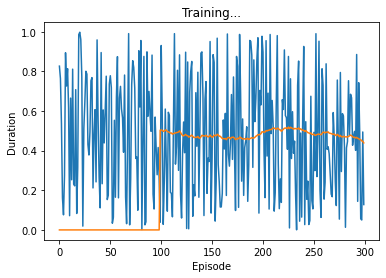

Episode 300 
 100, episode moving avg: 0.4389888644218445


In [18]:
plot(np.random.rand(300),100)

## Tensor Processing

In [19]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)

In [20]:
# Example Tensor Preprocess
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [21]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-Value Calculator

In [22]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

# Main Program

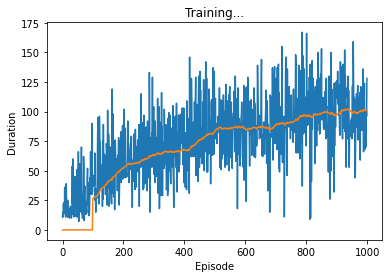

Episode 1000 
 100, episode moving avg: 100.6500015258789


In [23]:
batch_size = 256
gamma = 0.999
eps_start = 1 # epsilon
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # how frequently we updates the target networks' weights with the policy networks' weights: every 10 episode 
memory_size = 100000 
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # not training but evaluation only
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

##############################################################################
# Training
episode_durations = []
for episode in range(num_episodes):
    # for each episode, reset state and environment
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net) # policy net to choose explore or exploite
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
         
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()